# negotiating the past

To install the environment, see README.md

## setting up

We load the necessary libraries. If using colab, you might want to restart your kernel afterwards

In [1]:
!python --version
!pip install umap-learn
!pip install gensim
!pip install nltk
!pip install pandas

Python 3.11.12


In [2]:
# we mount google drive. Skip if you're not using google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating a Historical Prompt Dataset

In [3]:
# Loading the libraries
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import ssl

# Make sure you have the necessary NLTK resources

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')

# Read the CSV file -- we load only 10 000 rows and the first column for this dataset of prompts.
prompts_df = pd.read_csv("drive/MyDrive/data/prompts.csv", on_bad_lines='skip', nrows=1000, usecols=[0])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Historical Reference Detection Approach With DistilBERT

### Set up the pipeline

In [7]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.cluster import DBSCAN
from tqdm import tqdm  # Pour les barres de progression
import gc  # Nettoyage de mémoire
import os
from sentence_transformers import SentenceTransformer

# Définir le nombre de cœurs CPU à utiliser
num_cpu_cores = 8
torch.set_num_threads(num_cpu_cores)
os.environ["OMP_NUM_THREADS"] = str(num_cpu_cores)
os.environ["MKL_NUM_THREADS"] = str(num_cpu_cores)

def improved_historical_identification(prompts_df, sample_size=1000):
    """
    Version améliorée de l'identification des prompts historiques
    """
    # Échantillonnage si nécessaire
    if len(prompts_df) > sample_size:
        sample_df = prompts_df.sample(sample_size, random_state=42)
        print(f"Échantillonnage de {sample_size} prompts sur {len(prompts_df)} au total")
    else:
        sample_df = prompts_df.copy()
        print(f"Traitement de tous les {len(sample_df)} prompts")


    # Liste des prompts avec filtrage des valeurs non valides
    prompts_list = sample_df['prompt'].fillna('').tolist()
    valid_text_mask = [isinstance(text, str) and bool(text.strip()) for text in prompts_list]
    valid_prompts = [text for i, text in enumerate(prompts_list) if valid_text_mask[i]]

    print(f"Prompts valides : {len(valid_prompts)} sur {len(prompts_list)}")

    # Filtrer le DataFrame pour ne conserver que les lignes avec texte valide
    sample_df = sample_df[valid_text_mask].reset_index(drop=True)

    # Génération des embeddings
    print("Génération des embeddings des prompts...")
    print("Chargement du modèle SentenceTransformer...")
    model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

    # Traitement par lots pour économiser la mémoire
    batch_size = 32
    prompt_embeddings = []

    for i in tqdm(range(0, len(valid_prompts), batch_size), desc="Génération des embeddings"):
        batch = valid_prompts[i:i+batch_size]
        batch_embeddings = model.encode(batch, show_progress_bar=False)
        prompt_embeddings.append(batch_embeddings)

    prompt_embeddings = np.vstack(prompt_embeddings)

    # Vérifier que la longueur correspond
    assert len(sample_df) == prompt_embeddings.shape[0], "Incohérence entre la longueur du DataFrame et des embeddings"

    # Définir des concepts historiques plus diversifiés
    historical_concepts = [
        # Périodes historiques explicites
        "ancient history", "medieval times", "renaissance period",
        "world war", "cold war", "industrial revolution", "prehistoric era",

        # Termes plus généraux et implicites
        "history", "historical event", "in the past", "ancient times",
        "vintage", "retro", "old fashioned", "traditional",

        # Styles et esthétiques historiques
        "victorian style", "art deco", "baroque", "gothic", "classical",
        "midcentury", "ancient greek", "roman empire", "medieval knight",

        # Références à la culture populaire historique
        "steampunk", "dieselpunk", "historical fiction", "period drama",
        "historical costume", "historical setting"
    ]

    # Générer des embeddings pour les concepts historiques
    print("Génération des embeddings de concepts historiques...")
    historical_embeddings = model.encode(historical_concepts)

    # Calculer la similarité pour chaque concept
    print("Calcul des similarités...")
    concept_similarities = np.zeros((len(valid_prompts), len(historical_concepts)))

    for i in tqdm(range(0, len(valid_prompts), batch_size), desc="Calcul par lots"):
        end_idx = min(i + batch_size, len(valid_prompts))
        batch_embeddings = prompt_embeddings[i:end_idx]

        for j in range(len(historical_concepts)):
            concept_similarities[i:end_idx, j] = cosine_similarity(
                batch_embeddings,
                historical_embeddings[j].reshape(1, -1)
            ).flatten()

    # Pour chaque prompt, trouver le concept le plus similaire
    max_similarity_indices = np.argmax(concept_similarities, axis=1)
    max_similarities = np.max(concept_similarities, axis=1)

    # Attribuer des seuils différents selon les catégories de concepts
    concept_thresholds = {
        # Seuils plus élevés pour termes explicites
        "ancient history": 0.5,
        "medieval times": 0.5,
        "renaissance period": 0.5,
        "world war": 0.5,
        "cold war": 0.5,
        "industrial revolution": 0.5,

        # Seuils plus bas pour termes implicites ou généraux
        "history": 0.45,
        "historical event": 0.45,
        "in the past": 0.4,
        "ancient times": 0.45,

        # Seuils intermédiaires pour styles
        "victorian style": 0.48,
        "art deco": 0.48,
        "baroque": 0.48,
    }

    # Seuil par défaut pour les concepts non listés spécifiquement
    default_threshold = 0.45

    # Vérifier si chaque prompt dépasse le seuil pour son concept le plus similaire
    is_historical = []
    for i, (max_sim, concept_idx) in enumerate(zip(max_similarities, max_similarity_indices)):
        concept = historical_concepts[concept_idx]
        threshold = concept_thresholds.get(concept, default_threshold)
        is_historical.append(max_sim > threshold)

    # Convertir en array numpy pour faciliter l'indexation
    is_historical = np.array(is_historical)

    # Ajouter les résultats au DataFrame
    sample_df['most_similar_concept'] = [historical_concepts[idx] for idx in max_similarity_indices]
    sample_df['similarity_score'] = max_similarities
    sample_df['is_historical'] = is_historical

    # Filtrer les prompts historiques
    historical_prompts = sample_df[is_historical].copy()

    print(f"Identification de {len(historical_prompts)} prompts historiques ({len(historical_prompts)/len(sample_df):.2%} de l'échantillon)")

    # Méthode hybride - combiner embeddings et mots-clés pour améliorer la couverture
    keywords = [
        "history", "ancient", "medieval", "renaissance", "century",
        "war", "empire", "kingdom", "historical", "vintage", "retro",
        "traditional", "old", "classical", "antique"
    ]

    keyword_mask = sample_df['prompt'].fillna('').str.lower().str.contains('|'.join(keywords))
    missed_by_embedding = sample_df[~is_historical & keyword_mask].copy()
    missed_by_embedding['detection_method'] = 'keyword_only'

    # Ajouter un marqueur pour les prompts détectés par embedding
    historical_prompts['detection_method'] = 'embedding'

    # Fusionner les deux ensembles
    combined_historical = pd.concat([historical_prompts, missed_by_embedding], ignore_index=True)

    print(f"Identification supplémentaire de {len(missed_by_embedding)} prompts par mots-clés")
    print(f"Total de prompts historiques: {len(combined_historical)} ({len(combined_historical)/len(sample_df):.2%} de l'échantillon)")

    return combined_historical, prompt_embeddings, is_historical

def analyze_historical_clusters(historical_prompts, prompt_embeddings, is_historical):
    """
    Version adaptée pour fonctionner avec la nouvelle méthode d'identification
    """
    if len(historical_prompts) > 10:  # Besoin d'un minimum d'échantillons pour le clustering
        # Sélectionner les embeddings des prompts historiques identifiés par embedding
        embedding_historical = historical_prompts[historical_prompts['detection_method'] == 'embedding']

        # Créer un masque pour extraire les embeddings appropriés
        # Note: Cette approche suppose que les indices des historical_prompts correspondent
        # aux indices filtrés dans prompt_embeddings
        historical_indices = embedding_historical.index
        historical_embeddings = prompt_embeddings[historical_indices]

        print("Application de la réduction dimensionnelle UMAP...")
        # Appliquer UMAP avec optimisation CPU
        umap_model = UMAP(n_neighbors=15, min_dist=0.1, random_state=42,
                          n_jobs=num_cpu_cores)
        historical_umap = umap_model.fit_transform(historical_embeddings)

        print("Clustering avec DBSCAN...")
        # Appliquer DBSCAN
        dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=num_cpu_cores)
        cluster_labels = dbscan.fit_predict(historical_umap)

        # Ajouter les étiquettes de cluster au DataFrame, uniquement pour les prompts détectés par embedding
        # Initialiser une colonne de cluster avec des valeurs NaN
        historical_prompts['cluster'] = float('nan')

        # Mettre à jour les valeurs de cluster pour les prompts détectés par embedding
        idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(historical_indices)}
        for i, idx in enumerate(historical_indices):
            historical_prompts.loc[idx, 'cluster'] = cluster_labels[i]

        # Générer rapport et visualisations, uniquement pour les prompts avec clusters
        generate_cluster_report(embedding_historical, historical_umap, cluster_labels)

        return historical_prompts, historical_umap, cluster_labels
    else:
        print("Pas assez de prompts historiques pour le clustering")
        return historical_prompts, None, None

def generate_cluster_report(historical_prompts, historical_umap, cluster_labels):
    # Nombre de prompts par cluster
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    print("\nNombre de prompts par cluster:")
    print(cluster_counts)

    # Visualiser les clusters
    plt.figure(figsize=(12, 10))
    # Exclure les points de bruit (cluster -1) pour une meilleure visualisation
    non_noise_mask = cluster_labels != -1

    if np.any(non_noise_mask):  # Vérifier qu'il y a des points non-bruit
        scatter = plt.scatter(
            historical_umap[non_noise_mask, 0],
            historical_umap[non_noise_mask, 1],
            c=cluster_labels[non_noise_mask],
            cmap='tab20',
            alpha=0.6,
            s=10
        )
        plt.colorbar(scatter, label='Cluster')
    else:
        # S'il n'y a que des points de bruit, tous les afficher
        plt.scatter(
            historical_umap[:, 0],
            historical_umap[:, 1],
            c='gray',
            alpha=0.3,
            s=5
        )

    plt.title('Clusters des Prompts Historiques (méthode améliorée)')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.savefig('historical_prompt_clusters_improved.png', dpi=300, bbox_inches='tight')
#    plt.close()  # Fermer la figure pour libérer la mémoire

    # Exemples de prompts de chaque cluster
    print("\nExemples de prompts par cluster:")
    for cluster_id in sorted(set([label for label in cluster_labels if label != -1])):
        # Créer un masque pour ce cluster
        cluster_mask = cluster_labels == cluster_id

        # Trouver les indices correspondants dans historical_prompts
        cluster_indices = np.where(cluster_mask)[0]

        # Récupérer les lignes correspondantes
        if len(cluster_indices) > 0:
            # Échantillonner jusqu'à 5 prompts de ce cluster
            sample_indices = np.random.choice(cluster_indices, min(5, len(cluster_indices)), replace=False)

            print(f"\nCluster {cluster_id} ({len(cluster_indices)} prompts):")

            for idx in sample_indices:
                row_idx = historical_prompts.index[idx]
                row = historical_prompts.loc[row_idx]
                print(f"  - {row['prompt'][:100]}... (Similarité: {row['similarity_score']:.2f}, Concept: {row['most_similar_concept']})")

# Fonction principale pour exécuter l'ensemble du pipeline
def run_historical_prompt_analysis(prompts_df, sample_size=1000):
    # Identification des prompts historiques avec la méthode améliorée
    historical_prompts, prompt_embeddings, is_historical = improved_historical_identification(prompts_df, sample_size)

    # Analyse de clusters sur les prompts historiques identifiés
    historical_prompts_clustered, umap_result, cluster_labels = analyze_historical_clusters(
        historical_prompts, prompt_embeddings, is_historical)

    return historical_prompts_clustered, umap_result, cluster_labels


In [5]:
# we also export the CSVs

def export_clusters_to_csv(historical_prompts, output_dir="drive/MyDrive/data/generated/cluster_exports"):
    """
    Exporte les prompts regroupés par cluster dans des fichiers CSV distincts.
    Chaque fichier contient les prompts, scores de similarité et concepts associés.

    Parameters:
    -----------
    historical_prompts : pandas.DataFrame
        DataFrame contenant les prompts historiques avec les colonnes:
        - prompt: texte du prompt
        - similarity_score: score de similarité
        - most_similar_concept: concept historique le plus similaire
        - cluster: étiquette de cluster (-1 pour les points de bruit)
        - detection_method: méthode ayant détecté le prompt (embedding ou keyword_only)

    output_dir : str
        Répertoire de sortie pour les fichiers CSV
    """
    # Créer le répertoire de sortie s'il n'existe pas
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Répertoire créé: {output_dir}")

    # Extraire les prompts avec clusters valides (détection par embedding)
    clustered_prompts = historical_prompts[historical_prompts['cluster'].notna()].copy()

    # Ajouter une version tronquée du prompt pour la prévisualisation
    clustered_prompts['prompt_preview'] = clustered_prompts['prompt'].apply(
        lambda x: x[:100] + '...' if len(x) > 100 else x
    )

    # Créer un fichier récapitulatif pour tous les clusters
    summary_file = os.path.join(output_dir, "all_clusters_summary.csv")
    clusters_summary = clustered_prompts.groupby('cluster').agg(
        prompt_count=('prompt', 'count'),
        avg_similarity=('similarity_score', 'mean'),
        top_concepts=('most_similar_concept', lambda x: x.value_counts().index[0] if len(x) > 0 else 'N/A'),
        min_similarity=('similarity_score', 'min'),
        max_similarity=('similarity_score', 'max')
    ).reset_index()

    # Ajouter des exemples de prompts au résumé (3 exemples par cluster)
    def get_sample_prompts(group):
        if len(group) <= 3:
            return '; '.join(group['prompt_preview'].tolist())
        else:
            return '; '.join(group.sample(3)['prompt_preview'].tolist())

    sample_prompts = clustered_prompts.groupby('cluster').apply(get_sample_prompts).reset_index()
    sample_prompts.columns = ['cluster', 'sample_prompts']
    clusters_summary = pd.merge(clusters_summary, sample_prompts, on='cluster')

    # Enregistrer le résumé
    clusters_summary.to_csv(summary_file, index=False, encoding='utf-8')
    print(f"Résumé des clusters enregistré dans {summary_file}")

    # Exporter chaque cluster vers un fichier CSV distinct
    unique_clusters = clustered_prompts['cluster'].unique()

    for cluster_id in unique_clusters:
        # Ignorer les points de bruit pour l'exportation individuelle
        if cluster_id == -1:
            noise_file = os.path.join(output_dir, "noise_points.csv")
            noise_prompts = clustered_prompts[clustered_prompts['cluster'] == -1]
            if not noise_prompts.empty:
                noise_prompts.to_csv(noise_file, index=False, encoding='utf-8')
                print(f"Points de bruit ({len(noise_prompts)}) enregistrés dans {noise_file}")
            continue

        # Filtrer les prompts de ce cluster
        cluster_df = clustered_prompts[clustered_prompts['cluster'] == cluster_id].copy()

        # Trier par similarité décroissante
        cluster_df = cluster_df.sort_values('similarity_score', ascending=False)

        # Analyser les concepts présents dans ce cluster
        concept_counts = cluster_df['most_similar_concept'].value_counts()
        top_concepts = concept_counts.head(3).to_dict()  # Top 3 concepts

        # Créer un fichier avec un nom informatif
        top_concept = concept_counts.index[0] if len(concept_counts) > 0 else "inconnu"
        top_concept_safe = ''.join(c if c.isalnum() else '_' for c in top_concept)  # Nom de fichier sécurisé

        file_name = f"cluster_{int(cluster_id):02d}_{top_concept_safe}_{len(cluster_df)}_prompts.csv"
        file_path = os.path.join(output_dir, file_name)

        # Enregistrer ce cluster en CSV
        cluster_df.to_csv(file_path, index=False, encoding='utf-8')
        print(f"Cluster {int(cluster_id)} ({top_concept}, {len(cluster_df)} prompts) enregistré dans {file_name}")

    # Exporter les prompts détectés uniquement par mots-clés
    keyword_only = historical_prompts[historical_prompts['detection_method'] == 'keyword_only']
    if not keyword_only.empty:
        keyword_file = os.path.join(output_dir, "keyword_only_prompts.csv")
        keyword_only.to_csv(keyword_file, index=False, encoding='utf-8')
        print(f"Prompts détectés par mots-clés uniquement ({len(keyword_only)}) enregistrés dans {keyword_file}")

    # Créer un fichier HTML pour explorer les clusters
    create_html_explorer(historical_prompts, os.path.join(output_dir, "cluster_explorer.html"))

    return clusters_summary

def create_html_explorer(historical_prompts, output_file):
    """
    Crée un fichier HTML simple pour explorer les clusters de prompts.

    Parameters:
    -----------
    historical_prompts : pandas.DataFrame
        DataFrame contenant les prompts historiques avec clustering
    output_file : str
        Chemin vers le fichier HTML de sortie
    """
    # Extraire uniquement les prompts avec clusters valides
    clustered_prompts = historical_prompts[historical_prompts['cluster'].notna()].copy()

    # Récupérer la liste des clusters uniques (triés)
    unique_clusters = sorted(clustered_prompts['cluster'].unique())

    # Calculer des statistiques pour chaque cluster
    cluster_stats = {}
    for cluster_id in unique_clusters:
        if cluster_id == -1:  # Traiter les points de bruit séparément
            continue

        cluster_df = clustered_prompts[clustered_prompts['cluster'] == cluster_id]
        concept_counts = cluster_df['most_similar_concept'].value_counts().head(3)

        cluster_stats[cluster_id] = {
            'size': len(cluster_df),
            'avg_similarity': cluster_df['similarity_score'].mean(),
            'top_concepts': dict(concept_counts),
            'samples': cluster_df.sort_values('similarity_score', ascending=False).head(5)['prompt'].tolist()
        }

    # Générer le HTML
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Explorateur de Clusters de Prompts Historiques</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; line-height: 1.6; }
            h1 { color: #2c3e50; }
            h2 { color: #3498db; margin-top: 30px; }
            .cluster { border: 1px solid #ddd; padding: 15px; margin: 15px 0; border-radius: 5px; }
            .cluster-header { display: flex; justify-content: space-between; }
            .concept-tag { display: inline-block; background: #e0f7fa; padding: 3px 8px; margin: 3px; border-radius: 3px; }
            .prompt-item { padding: 8px; margin: 5px 0; background: #f9f9f9; border-left: 3px solid #3498db; }
            .similarity { font-size: 0.8em; color: #666; }
            .stats { color: #7f8c8d; font-size: 0.9em; }
            .toggle-button { background: #3498db; color: white; border: none; padding: 5px 10px; cursor: pointer; border-radius: 3px; }
            .prompt-list { max-height: 0; overflow: hidden; transition: max-height 0.3s ease-out; }
            .expanded { max-height: 2000px; }
            .search-container { margin: 20px 0; }
            #searchInput { padding: 8px; width: 250px; }
            #statsSection { margin-top: 30px; }
        </style>
    </head>
    <body>
        <h1>Explorateur de Clusters de Prompts Historiques</h1>

        <div class="search-container">
            <input type="text" id="searchInput" placeholder="Rechercher des prompts...">
            <button onclick="searchPrompts()">Rechercher</button>
        </div>

        <div id="statsSection">
            <h2>Statistiques générales</h2>
            <p>Nombre total de clusters: <strong>""" + str(len(cluster_stats)) + """</strong></p>
            <p>Nombre total de prompts clusterisés: <strong>""" + str(len(clustered_prompts)) + """</strong></p>
        </div>

        <div id="clustersSection">
    """

    # Ajouter chaque cluster au HTML
    for cluster_id in sorted([c for c in unique_clusters if c != -1]):
        stats = cluster_stats[cluster_id]

        # Créer les balises de concepts
        concept_tags = ""
        for concept, count in stats['top_concepts'].items():
            concept_tags += f'<span class="concept-tag">{concept} ({count})</span>'

        # Ajouter les prompts échantillons
        prompt_items = ""
        for i, prompt in enumerate(stats['samples']):
            # Raccourcir le prompt pour l'affichage
            display_prompt = prompt[:200] + "..." if len(prompt) > 200 else prompt
            prompt_items += f'<div class="prompt-item">{i+1}. {display_prompt}</div>'

        # Créer la section de cluster
        html_content += f"""
        <div class="cluster" data-cluster-id="{int(cluster_id)}">
            <div class="cluster-header">
                <h3>Cluster {int(cluster_id)}</h3>
                <button class="toggle-button" onclick="togglePrompts(this)">Afficher les prompts</button>
            </div>
            <div class="stats">
                <p><strong>Taille:</strong> {stats['size']} prompts | <strong>Similarité moyenne:</strong> {stats['avg_similarity']:.2f}</p>
                <p><strong>Concepts principaux:</strong> {concept_tags}</p>
            </div>
            <div class="prompt-list">
                <h4>Exemples de prompts:</h4>
                {prompt_items}
            </div>
        </div>
        """

    # Ajouter les points de bruit
    noise_df = clustered_prompts[clustered_prompts['cluster'] == -1]
    if len(noise_df) > 0:
        noise_samples = noise_df.sample(min(5, len(noise_df)))['prompt'].tolist()
        noise_items = ""
        for i, prompt in enumerate(noise_samples):
            display_prompt = prompt[:200] + "..." if len(prompt) > 200 else prompt
            noise_items += f'<div class="prompt-item">{i+1}. {display_prompt}</div>'

        html_content += f"""
        <div class="cluster">
            <div class="cluster-header">
                <h3>Points de bruit</h3>
                <button class="toggle-button" onclick="togglePrompts(this)">Afficher les prompts</button>
            </div>
            <div class="stats">
                <p><strong>Taille:</strong> {len(noise_df)} prompts</p>
            </div>
            <div class="prompt-list">
                <h4>Exemples de prompts:</h4>
                {noise_items}
            </div>
        </div>
        """

    # Ajouter le JavaScript et fermer les balises HTML
    html_content += """
        </div>

        <script>
            function togglePrompts(button) {
                const list = button.parentNode.nextElementSibling.nextElementSibling;
                list.classList.toggle('expanded');
                button.textContent = list.classList.contains('expanded') ? 'Masquer les prompts' : 'Afficher les prompts';
            }

            function searchPrompts() {
                const searchTerm = document.getElementById('searchInput').value.toLowerCase();
                const clusters = document.querySelectorAll('.cluster');

                if (searchTerm === '') {
                    // Si la recherche est vide, afficher tous les clusters
                    clusters.forEach(cluster => {
                        cluster.style.display = 'block';
                    });
                    return;
                }

                clusters.forEach(cluster => {
                    const promptItems = cluster.querySelectorAll('.prompt-item');
                    let matchFound = false;

                    promptItems.forEach(item => {
                        if (item.textContent.toLowerCase().includes(searchTerm)) {
                            matchFound = true;
                        }
                    });

                    // Aussi vérifier dans les concepts
                    const conceptTags = cluster.querySelectorAll('.concept-tag');
                    conceptTags.forEach(tag => {
                        if (tag.textContent.toLowerCase().includes(searchTerm)) {
                            matchFound = true;
                        }
                    });

                    cluster.style.display = matchFound ? 'block' : 'none';
                });
            }
        </script>
    </body>
    </html>
    """

    # Écrire le HTML dans un fichier
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_content)

    print(f"Explorateur HTML créé: {output_file}")



### Run the pipline

Traitement de tous les 1000 prompts
Prompts valides : 987 sur 1000
Génération des embeddings des prompts...
Chargement du modèle SentenceTransformer...


Génération des embeddings: 100%|██████████| 31/31 [05:59<00:00, 11.61s/it]


Génération des embeddings de concepts historiques...
Calcul des similarités...


Calcul par lots: 100%|██████████| 31/31 [00:01<00:00, 18.09it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Identification de 73 prompts historiques (7.40% de l'échantillon)
Identification supplémentaire de 163 prompts par mots-clés
Total de prompts historiques: 236 (23.91% de l'échantillon)
Application de la réduction dimensionnelle UMAP...
Clustering avec DBSCAN...

Nombre de prompts par cluster:
-1    16
 0    13
 1     7
 2    16
 3     6
 4     8
 5     7
Name: count, dtype: int64

Exemples de prompts par cluster:

Cluster 0 (13 prompts):
  - Slumpunk Cyberpunk City from street view by Dylan Cole , unreal 5, hyperrealistic, realistic, photor... (Similarité: 0.53, Concept: dieselpunk)
  - a godlike and indomitable helmeted , masked and armored samurai .samurai temple and Rising sun in ba... (Similarité: 0.48, Concept: historical costume)
  - Maria evades sgt rhodes. Cyberpunk hacker escaping Menacing Cyberpunk police trooper wearing a comba... (Similarité: 0.47, Concept: steampunk)
  - Greg Manchess portrait painting of Michelangelo of TMNT as Overwatch character, medium shot, asymmet...

NameError: name 'historical_prompts_clustered' is not defined

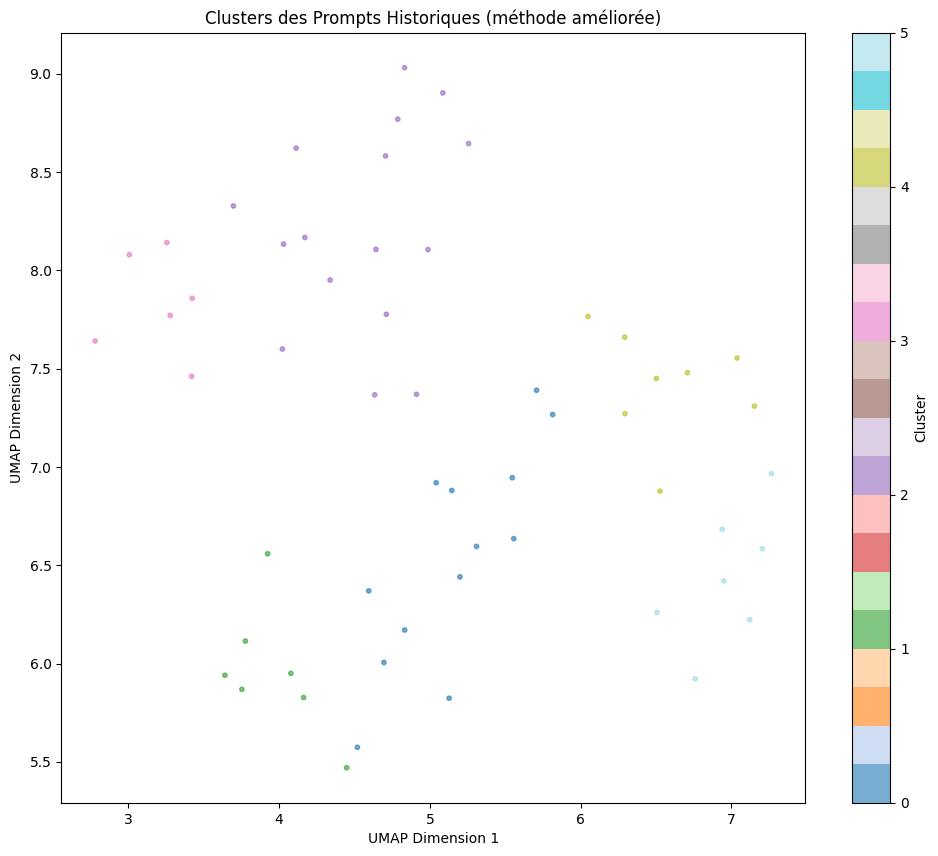

In [8]:
# Exécuter l'analyse et utiliser directement le résultat
results, _, _ = run_historical_prompt_analysis(prompts_df)

#historical_prompts.to_csv()
historical_prompts_clustered.to_csv(drive/MyDrive/data/generated/historical_prompts_clustered.csv)
umap_result.to_csv(drive/MyDrive/data/generated/umap_result.csv)
cluster_labels.to_csv(drive/MyDrive/data/generated/cluster_labels.csv)
historical_prompts.to_csv(drive/MyDrive/data/generated/historical_prompts.csv)
prompt_embeddings.to_csv(drive/MyDrive/data/generated/prompt_embeddings.csv)
is_historical.to_csv(drive/MyDrive/data/generated/is_historical.csv)


# Exporter avec les résultats
summary = export_clusters_to_csv(results)

## Dataviz

### 1. Visualisation de la distribution des scores de similarité

Cette cellule permet de visualiser comment les scores de similarité sont distribués et d'évaluer si le seuil choisi (0.6) est approprié

In [ ]:
def visualize_similarity_distribution(similarity_scores, threshold=0.6, output_path='./figures/'):
    """
    Visualise la distribution des scores de similarité et marque le seuil utilisé.

    Args:
        similarity_scores: Tableau numpy des scores de similarité
        threshold: Seuil utilisé pour filtrer les prompts historiques
        output_path: Chemin pour sauvegarder les figures
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    os.makedirs(output_path, exist_ok=True)

    plt.figure(figsize=(10, 6))

    # Histogramme des scores de similarité
    plt.hist(similarity_scores, bins=50, alpha=0.7, color='steelblue')

    # Ligne verticale pour le seuil
    plt.axvline(x=threshold, color='red', linestyle='--',
                label=f'Seuil ({threshold})')

    # Annotations
    plt.title('Distribution des scores de similarité avec les concepts historiques',
              fontsize=14)
    plt.xlabel('Score de similarité', fontsize=12)
    plt.ylabel('Nombre de prompts', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # Annotation des statistiques clés
    plt.text(0.02, 0.95,
             f"Total: {len(similarity_scores)}\nHistoriques: {np.sum(similarity_scores > threshold)} ({np.mean(similarity_scores > threshold):.1%})",
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'similarity_distribution.png'), dpi=300)
    plt.show()

# D'abord, exécutez le pipeline principal pour générer les données nécessaires si pas déjà fait
# historical_prompts, prompt_embeddings, max_similarities = process_prompts_for_historical_content(prompts_df)

# Exemple d'utilisation
visualize_similarity_distribution(max_similarities)

### 2. Carte de chaleur des similarités entre concepts historiques

Cette cellule permet de visualiser comment les concepts historiques sont reliés entre eux

In [ ]:
def visualize_historical_concepts_similarity(historical_concepts, historical_embeddings, output_path='./figures/'):
    """
    Crée une carte de chaleur montrant les similarités entre concepts historiques.

    Args:
        historical_concepts: Liste des concepts historiques
        historical_embeddings: Embeddings des concepts historiques
        output_path: Chemin pour sauvegarder les figures
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from sklearn.metrics.pairwise import cosine_similarity
    import os

    os.makedirs(output_path, exist_ok=True)

    # Calculer la matrice de similarité entre concepts
    concept_similarity = cosine_similarity(historical_embeddings)

    # Créer une figure de taille appropriée
    plt.figure(figsize=(12, 10))

    # Créer la heatmap avec seaborn
    sns.heatmap(concept_similarity, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=historical_concepts, yticklabels=historical_concepts)

    plt.title("Similarité entre les concepts historiques", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'historical_concepts_similarity.png'), dpi=300)
    plt.show()

# Exemple d'utilisation
visualize_historical_concepts_similarity(historical_concepts, historical_embeddings)

### 3. Projection UMAP des prompts avec coloration par concept le plus similaire
Cette visualisation permet de voir comment les prompts se regroupent naturellement et si les concepts les plus similaires forment des clusters cohérents

In [ ]:
def visualize_umap_by_concept(historical_prompts, historical_umap, output_path='./figures/'):
    """
    Visualise la projection UMAP des prompts, colorés par concept historique le plus similaire.

    Args:
        historical_prompts: DataFrame contenant les prompts historiques avec leur concept le plus similaire
        historical_umap: Coordonnées UMAP des prompts historiques
        output_path: Chemin pour sauvegarder les figures
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    from matplotlib.colors import ListedColormap

    os.makedirs(output_path, exist_ok=True)

    # Obtenir les concepts uniques
    unique_concepts = historical_prompts['most_similar_concept'].unique()
    n_concepts = len(unique_concepts)

    # Créer un mapping des concepts aux indices
    concept_to_idx = {concept: i for i, concept in enumerate(unique_concepts)}

    # Obtenir un tableau numpy des indices de concepts
    concept_indices = np.array([concept_to_idx[concept] for concept in historical_prompts['most_similar_concept']])

    # Créer une colormap avec suffisamment de couleurs distinctes
    import matplotlib.cm as cm
    if n_concepts <= 10:
        cmap = ListedColormap(plt.cm.tab10.colors[:n_concepts])
    elif n_concepts <= 20:
        cmap = ListedColormap(plt.cm.tab20.colors[:n_concepts])
    else:
        cmap = plt.cm.nipy_spectral

    plt.figure(figsize=(14, 10))

    # Scatter plot avec coloration par concept
    scatter = plt.scatter(historical_umap[:, 0], historical_umap[:, 1],
                         c=concept_indices, cmap=cmap,
                         alpha=0.7, s=10)

    # Créer une légende explicite
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=cmap(concept_to_idx[concept]),
                              markersize=8, label=concept)
                       for concept in unique_concepts]

    plt.legend(handles=legend_elements, loc='upper right',
               bbox_to_anchor=(1.1, 1), ncol=1)

    plt.title('Projection UMAP des prompts historiques par concept', fontsize=14)
    plt.xlabel('UMAP Dimension 1', fontsize=12)
    plt.ylabel('UMAP Dimension 2', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'umap_by_concept.png'), dpi=300)
    plt.show()

# Exemple d'utilisation
visualize_umap_by_concept(historical_prompts, historical_umap)

### 4. Nuage de mots pour chaque cluster

Cette visualisation permet d'explorer les termes les plus fréquents dans chaque cluster

In [ ]:
def generate_cluster_wordclouds(historical_prompts, output_path='./figures/'):
    """
    Génère un nuage de mots pour chaque cluster identifié.

    Args:
        historical_prompts: DataFrame contenant les prompts historiques avec leurs clusters
        output_path: Chemin pour sauvegarder les figures
    """
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    import os
    import nltk
    from nltk.corpus import stopwords

    # Télécharger les stopwords si nécessaire
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')

    stop_words = set(stopwords.words('english'))

    os.makedirs(output_path, exist_ok=True)

    # Pour chaque cluster
    for cluster_id in sorted(historical_prompts['cluster'].unique()):
        if cluster_id == -1:  # Ignorer les points de bruit
            continue

        # Filtrer les prompts de ce cluster
        cluster_prompts = historical_prompts[historical_prompts['cluster'] == cluster_id]['prompt']

        if len(cluster_prompts) == 0:
            continue

        # Combiner tous les textes
        text = ' '.join(cluster_prompts)

        # Créer le nuage de mots
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            stopwords=stop_words,
            max_words=100,
            contour_width=3
        ).generate(text)

        # Afficher et sauvegarder
        plt.figure(figsize=(16, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Nuage de mots pour le Cluster {cluster_id} ({len(cluster_prompts)} prompts)',
                 fontsize=16)
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, f'wordcloud_cluster_{cluster_id}.png'), dpi=300)
        plt.close()

    print(f"Nuages de mots générés pour {len(historical_prompts['cluster'].unique()) - 1} clusters")

# Exemple d'utilisation
generate_cluster_wordclouds(historical_prompts)

### 5. Distribution des concepts historiques par cluster
Cette visualisation montre comment les différents concepts historiques sont distribués dans les clusters identifiés

In [ ]:
def visualize_concepts_by_cluster(historical_prompts, output_path='./figures/'):
    """
    Crée une heatmap montrant la distribution des concepts historiques par cluster.

    Args:
        historical_prompts: DataFrame contenant les prompts historiques
        output_path: Chemin pour sauvegarder les figures
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import os

    os.makedirs(output_path, exist_ok=True)

    # Ignorer les points de bruit (cluster -1) si présents
    if -1 in historical_prompts['cluster'].unique():
        df_filtered = historical_prompts[historical_prompts['cluster'] != -1].copy()
    else:
        df_filtered = historical_prompts.copy()

    # Créer une table de contingence
    cross_tab = pd.crosstab(
        df_filtered['most_similar_concept'],
        df_filtered['cluster'],
        normalize='index'
    )

    # Tri pour une meilleure visualisation
    # On trie les concepts par cluster dominant
    dominant_clusters = cross_tab.idxmax(axis=1)
    sorted_concepts = dominant_clusters.sort_values().index
    cross_tab = cross_tab.loc[sorted_concepts]

    plt.figure(figsize=(14, 10))
    sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='.0%')
    plt.title('Distribution des concepts historiques par cluster', fontsize=16)
    plt.ylabel('Concept historique', fontsize=14)
    plt.xlabel('Cluster', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'concept_cluster_distribution.png'), dpi=300)
    plt.show()

# Exemple d'utilisation
visualize_concepts_by_cluster(historical_prompts)

### 6. Analyse des termes les plus communs par concept historique

Cette visualisation aide à comprendre quels termes sont les plus associés à chaque concept historique

In [ ]:
def analyze_terms_by_concept(historical_prompts, output_path='./figures/'):
    """
    Analyse et visualise les termes les plus fréquents pour chaque concept historique.

    Args:
        historical_prompts: DataFrame contenant les prompts historiques
        output_path: Chemin pour sauvegarder les figures
    """
    import matplotlib.pyplot as plt
    import os
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from collections import Counter

    # Télécharger les ressources NLTK nécessaires
    try:
        nltk.data.find('tokenizers/punkt')
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('punkt')
        nltk.download('stopwords')

    stop_words = set(stopwords.words('english'))

    os.makedirs(output_path, exist_ok=True)

    # Pour chaque concept historique
    for concept in historical_prompts['most_similar_concept'].unique():
        # Filtrer les prompts de ce concept
        concept_prompts = historical_prompts[historical_prompts['most_similar_concept'] == concept]['prompt']

        # Combiner tous les prompts
        text = ' '.join(concept_prompts)

        # Tokenizer
        tokens = word_tokenize(text.lower())

        # Filtrer les stopwords et les tokens courts
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words and len(word) > 2]

        # Compter les occurrences
        word_counts = Counter(filtered_tokens)

        # Prendre les N mots les plus fréquents
        top_n = 20
        top_words = word_counts.most_common(top_n)

        # Préparer les données pour le graphique
        words = [word for word, count in top_words]
        counts = [count for word, count in top_words]

        # Créer le graphique
        plt.figure(figsize=(12, 8))
        plt.barh(words[::-1], counts[::-1], color='steelblue')
        plt.xlabel('Fréquence')
        plt.title(f'Termes les plus fréquents pour "{concept}" ({len(concept_prompts)} prompts)',
                 fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, f'terms_{concept.replace(" ", "_")}.png'), dpi=300)
        plt.close()

    print(f"Analyse des termes générée pour {len(historical_prompts['most_similar_concept'].unique())} concepts")

# Exemple d'utilisation
analyze_terms_by_concept(historical_prompts)

### 7. Visualisation interactive avec Plotly

Cette cellule crée une visualisation interactive de la projection UMAP qui permet d'explorer les prompts historiques de manière plus interactive

In [ ]:
def create_interactive_visualization(historical_prompts, historical_umap, output_path='./figures/'):
    """
    Crée une visualisation interactive des prompts historiques avec Plotly.

    Args:
        historical_prompts: DataFrame contenant les prompts historiques
        historical_umap: Coordonnées UMAP des prompts historiques
        output_path: Chemin pour sauvegarder les figures
    """
    import plotly.express as px
    import pandas as pd
    import os

    os.makedirs(output_path, exist_ok=True)

    # Créer un DataFrame pour Plotly
    viz_df = pd.DataFrame({
        'UMAP1': historical_umap[:, 0],
        'UMAP2': historical_umap[:, 1],
        'Cluster': historical_prompts['cluster'],
        'Concept': historical_prompts['most_similar_concept'],
        'Score': historical_prompts['similarity_score'],
        'Prompt': historical_prompts['prompt']
    })

    # Créer la visualisation interactive
    fig = px.scatter(
        viz_df,
        x='UMAP1',
        y='UMAP2',
        color='Concept',
        hover_data=['Prompt', 'Score', 'Cluster'],
        opacity=0.7,
        title='Exploration interactive des prompts historiques',
        template='plotly_white',
        color_discrete_sequence=px.colors.qualitative.Bold
    )

    # Améliorer la mise en page
    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.2,
            xanchor="center",
            x=0.5
        ),
        width=1200,
        height=800
    )

    # Enregistrer en tant que fichier HTML autonome
    fig.write_html(os.path.join(output_path, 'interactive_visualization.html'))

    return fig

# Exemple d'utilisation
fig = create_interactive_visualization(historical_prompts, historical_umap)
fig.show()  # Afficher dans le notebook

### 8. Réseau de co-occurrence de concepts dans les clusters
Cette visualisation montre comment les concepts historiques sont liés entre eux à travers leur présence dans les mêmes clusters

In [ ]:
def visualize_concept_network(historical_prompts, output_path='./figures/'):
    """
    Crée une visualisation en réseau des relations entre concepts historiques
    basée sur leur co-occurrence dans les clusters.

    Args:
        historical_prompts: DataFrame contenant les prompts historiques
        output_path: Chemin pour sauvegarder les figures
    """
    import networkx as nx
    import matplotlib.pyplot as plt
    import pandas as pd
    import os

    os.makedirs(output_path, exist_ok=True)

    # Filtrer pour exclure les points de bruit
    if -1 in historical_prompts['cluster'].unique():
        df_filtered = historical_prompts[historical_prompts['cluster'] != -1].copy()
    else:
        df_filtered = historical_prompts.copy()

    # Créer un graphe
    G = nx.Graph()

    # Ajouter des nœuds pour chaque concept
    concepts = df_filtered['most_similar_concept'].unique()
    for concept in concepts:
        count = df_filtered[df_filtered['most_similar_concept'] == concept].shape[0]
        G.add_node(concept, size=count, count=count)

    # Pour chaque cluster, créer des liens entre concepts présents
    for cluster in df_filtered['cluster'].unique():
        # Obtenir les concepts dans ce cluster
        cluster_concepts = df_filtered[df_filtered['cluster'] == cluster]['most_similar_concept'].unique()

        # Créer des liens pour chaque paire de concepts
        for i, concept1 in enumerate(cluster_concepts):
            for concept2 in cluster_concepts[i+1:]:
                # Si le lien existe déjà, augmenter son poids
                if G.has_edge(concept1, concept2):
                    G[concept1][concept2]['weight'] += 1
                else:
                    G.add_edge(concept1, concept2, weight=1)

    # Taille des nœuds basée sur la fréquence
    node_sizes = [G.nodes[node]['size'] * 20 for node in G.nodes]

    # Épaisseur des liens basée sur les poids
    edge_weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges]

    # Positionner les nœuds
    pos = nx.spring_layout(G, seed=42, k=0.3)

    plt.figure(figsize=(14, 12))

    # Dessiner les nœuds
    nx.draw_networkx_nodes(G, pos,
                          node_size=node_sizes,
                          node_color='skyblue',
                          alpha=0.8)

    # Dessiner les liens
    nx.draw_networkx_edges(G, pos,
                          width=edge_weights,
                          alpha=0.5,
                          edge_color='gray')

    # Ajouter les étiquettes
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.title('Réseau de co-occurrence des concepts historiques', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'concept_network.png'), dpi=300, bbox_inches='tight')
    plt.show()

    return G

# Exemple d'utilisation
concept_network = visualize_concept_network(historical_prompts)